# Partial dependence plots

This notebook calculates partial dependence values for the models, then creates PD plots for each input feature.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

In [1]:
config_file = "notebook_parameters_default.yml"

In [2]:
from lib.load_params import get_params

params = get_params(config_file, notebook="07")

# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = params["use_extracted_data"]

# Number of processes to use
n_jobs = params["n_jobs"]

# Overwrite any existing output files
# (calculating partial dependence can be time-consuming)
overwrite = params["overwrite_output"]

# Number of input values at which to calculate partial dependence
grid_resolution = params["grid_resolution"]

# Seed for random number generator (for downsampling data)
random_seed = params["random_seed"]

# Output directory
output_dir = params["output_dir"]

These values will usually not need to be modified:

In [3]:
labelled_ratio = 0.5  # num_labelled / num_unlabelled (for downsampling data)

## Notebook setup

Imports, definitions, etc.

### Imports

In [4]:
import os
import warnings
from itertools import zip_longest

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import to_rgba
from matplotlib import MatplotlibDeprecationWarning
from matplotlib.gridspec import GridSpec
from sklearn.inspection import partial_dependence

from lib.check_files import check_prepared_data
from lib.misc import format_feature_name

# Suppress FutureWarning for some versions of Scikit-learn
%env PYTHONWARNINGS=ignore::FutureWarning
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", MatplotlibDeprecationWarning)

env: PYTHONWARNINGS=ignore::FutureWarning


### Input and output files

In [5]:
if use_extracted_data:
    data_dir = params["extracted_data_dir"]
else:
    data_dir = check_prepared_data("prepared_data", verbose=True)

data_filename = os.path.join(data_dir, "training_data_global.csv")
grid_data_filename = os.path.join(data_dir, "grid_data.csv")
output_dir = os.path.join(
    output_dir,
    "global",
    "PU",
)

pd_dir = os.path.join(output_dir, "partial_dependence")
os.makedirs(pd_dir, exist_ok=True)
output_basename = os.path.join(pd_dir, "partial_dependence")

data = pd.read_csv(data_filename)
grid_data = pd.read_csv(grid_data_filename)

regions = ("North America", "South America", "Southeast Asia", "Tethys")

positives = data[data["label"] == "positive"]
positives_subset = positives[positives["region"].isin(regions)]

random = data[data["label"] == "unlabelled"]
random_subset = random[random["region"].isin(regions)]

In [6]:
# Boxplots
gb_positives = positives.groupby("region")
gb_random = random.groupby("region")
regions_boxplots = (
    "North America",
    "South America",
    "Global",
    "Southeast Asia",
    "Tethys",
)
colors_boxplots = (
    "blue",
    "orange",
    "magenta",
    "green",
    "red",
)

## Calculate partial dependence

Partial dependence is calculated separately for all input features of each model.

### Global model

In [7]:
model_filename = os.path.join(
    output_dir,
    "classifier.joblib",
)
model = joblib.load(model_filename)
try:
    # Each process seems to be able to effectively use
    # roughly 2 threads
    model["classifier"].set_params(n_jobs=2)
except ValueError:
    pass

# Use equal number of labelled and unlabelled
rng = np.random.default_rng(random_seed)
n_labelled = (data["label"] != "unlabelled").sum()
unlabelled_idx = (data[data["label"] == "unlabelled"]).index
sample_idx = rng.choice(
    unlabelled_idx,
    size=np.int_(n_labelled / labelled_ratio),
    replace=True,  # bootstrap
)
data_global = pd.concat(
    (
        data[data["label"] != "unlabelled"],
        data.loc[sample_idx, :],
    )
)

# Use random subset of global gridded data)
n_points = 2000
data_global = pd.DataFrame(
    grid_data.loc[
        rng.choice(
            grid_data.index,
            size=n_points,
            replace=True,  # bootstrap
        ),
        :
    ]
)

preprocessing = model["preprocessing"]
imputer = preprocessing["iterativeimputer"]
X = imputer.transform(data_global[imputer.feature_names_in_])
feature_names = preprocessing.get_feature_names_out()

prefer = "processes"
if not os.path.isfile(output_basename + ".joblib") or overwrite:
    with joblib.Parallel(n_jobs // 2, prefer=prefer) as parallel:
        pd_results = parallel(
            joblib.delayed(partial_dependence)(
                estimator=model,
                X=X,
                features=fname,
                grid_resolution=grid_resolution,
                kind="both",
            )
            for fname in feature_names
        )
    joblib.dump([dict(i) for i in pd_results], output_basename + ".joblib")
else:
    pd_results = joblib.load(output_basename + ".joblib")

The features below are sorted in order of decreasing partial dependence ranges (larger range, greater influence on predicted probability):

In [8]:
pd_ranges = [np.nanmax(i["average"]) - np.nanmin(i["average"]) for i in pd_results]
order = np.argsort(pd_ranges)[::-1]
for i, idx in enumerate(order):
    print(f"{i + 1}:", feature_names[idx])

1: crustal_thickness_mean (m)
2: distance_to_trench (km)
3: sediment_thickness (m)
4: distance_to_trench_edge (km)
5: total_carbon_density (t/m^2)
6: seafloor_spreading_rate (km/Myr)
7: slab_dip (degrees)
8: trench_velocity_parallel (cm/yr)
9: seafloor_age (Ma)
10: convergence_rate_parallel (cm/yr)
11: trench_velocity_orthogonal (cm/yr)
12: slab_flux (m^2/yr)
13: distance_from_trench_start (km)
14: crustal_thickness_min (m)
15: subducted_sediment_volume (m)
16: trench_velocity_obliquity (degrees)
17: subducting_plate_absolute_velocity_parallel (cm/yr)


### Regional models

In [9]:
pd_results_regions = {}
feature_names_regions = {}
for region in regions:
    r = "_".join(region.lower().split())
    model_filename_region = os.path.join(
        output_dir,
        f"classifier_{r}.joblib",
    )
    model_region = joblib.load(model_filename_region)
    try:
        # Each process seems to be able to effectively use
        # roughly 2 threads
        model_region["classifier"].set_params(n_jobs=2)
    except ValueError:
        pass

    preprocessing_region = model_region["preprocessing"]
    imputer_region = preprocessing_region["iterativeimputer"]
    X_region = imputer_region.transform(
        data_global[imputer_region.feature_names_in_]
    )
    feature_names_region = preprocessing_region.get_feature_names_out()
    feature_names_regions[region] = feature_names_region

    prefer = "processes"
    if not os.path.isfile(f"{output_basename}_{r}" + ".joblib") or overwrite:
        with joblib.Parallel(n_jobs // 2, prefer=prefer) as parallel:
            pd_results_region = parallel(
                joblib.delayed(partial_dependence)(
                    estimator=model_region,
                    X=X_region,
                    features=fname,
                    grid_resolution=grid_resolution,
                    kind="both",
                )
                for fname in feature_names_region
            )
        joblib.dump(
            [dict(i) for i in pd_results_region],
            f"{output_basename}_{r}" + ".joblib",
        )
    else:
        pd_results_region = joblib.load(f"{output_basename}_{r}" + ".joblib")
    pd_results_regions[region] = pd_results_region

## Create plots

### Global model

For the global model, both individual and mean partial dependence curves are plotted.

#### Example: total carbon density

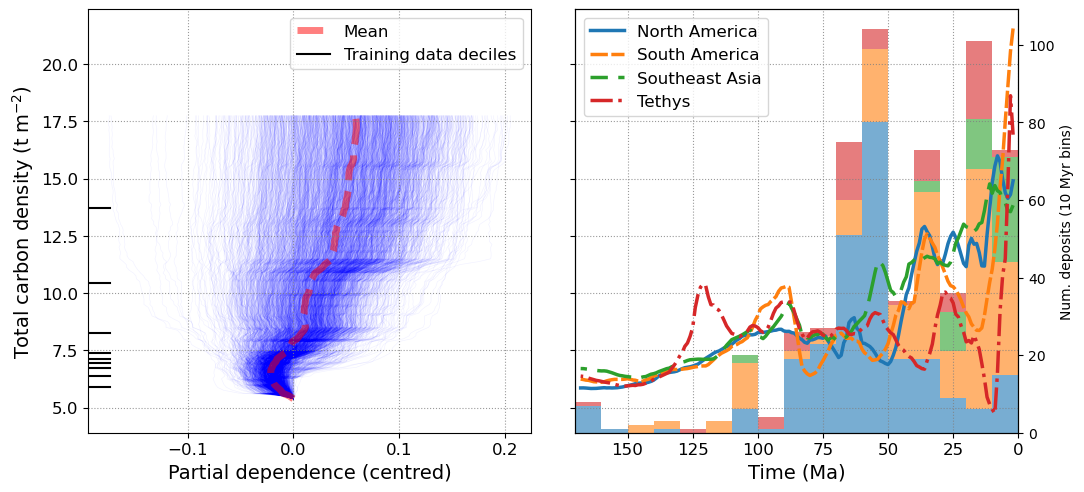

In [10]:
feature_name = "total_carbon_density (t/m^2)"
centred = True  # centre partial dependence plots
window_size = 5  # Myr window for rolling average
hist_bin_size = 10  # Myr bin size for histogram

idx = np.squeeze(np.where(feature_names == feature_name))

x = pd_results[idx]["grid_values"][0]
ys = pd_results[idx]["individual"][0].T
y_av = pd_results[idx]["average"][0]
if centred:
    ys = ys - ys[0, :]
    y_av = y_av - y_av[0]

deciles = [
    X[feature_name].quantile(i)
    for i in np.arange(0.1, 1.0, 0.1)
]

fig, axs = plt.subplots(
    1, 2,
    figsize=(12, 5.5),
    sharey=True,
    gridspec_kw=dict(
        wspace=0.1,
    ),
)
ax1, ax2 = np.ravel(axs)
ax1.plot(
    ys,
    x,
    color="blue",
    alpha=0.05,
    linewidth=0.5,
    zorder=0,
)
ax1.plot(
    y_av,
    x,
    color="red",
    alpha=0.5,
    linewidth=5,
    linestyle="dashed",
    zorder=1,
    label="Mean",
)

ax1.set_ylim(
    x.min(),
    x.max(),
)
if centred:
    ax1.set_xlabel("Partial dependence (centred)", fontsize=14)
    ax1.set_xlim(*ax1.get_xlim())
else:
    ax1.set_xlabel("Probability", fontsize=14)
    ax1.set_xlim(0, 1)
ax1.set_ylabel(format_feature_name(feature_name), fontsize=14)

tick_height = 0.05 * (ax1.get_xlim()[1] - ax1.get_xlim()[0])
tick_ys = (ax1.get_xlim()[0], tick_height + ax1.get_xlim()[0])
l = "Training data deciles"
for tick_x in deciles:
    ax1.plot(
        tick_ys,
        [tick_x] * 2,
        color="black",
        label=l,
    )
    l = None
ax1.legend(loc="best", fontsize=12)

ymin = np.inf
ymax = -np.inf
colors = []
linestyles = (
    "solid",
    (0, (5, 1)),
    (5, (10, 3)),
    "dashdot",
)
for region, linestyle in zip_longest(sorted(regions), linestyles):
    subset = grid_data.groupby("region").get_group(region)
    s = subset.groupby("age (Ma)")[feature_name].quantile(0.5)
    if window_size is not None:
        s = s.rolling(window_size, center=True).mean()
    l = ax2.plot(
        s.index,
        s,
        label=region,
        linewidth=2.5,
        linestyle=linestyle,
    )[0]
    colors.append(to_rgba(l.get_color(), alpha=0.6))
    ymin = np.min((ymin, s.min()))
    ymax = np.max((ymax, s.max()))
yrange = ymax - ymin
ax2.set_ylim(
    ymin - yrange * 0.05,
    ymax + yrange * 0.05,
)
ax2.legend(loc="best", fontsize=12)
ax2.set_xlim(s.index.max(), s.index.min())
ax2.set_xlabel("Time (Ma)", fontsize=14)

ax3 = ax2.twinx()
bins = np.arange(
    0,
    positives_subset["age (Ma)"].max() + hist_bin_size,
    hist_bin_size,
)
(
    positives_subset
        .pivot(columns="region")
        ["age (Ma)"]
        .sort_index(axis="columns")
        .plot(
            kind="hist",
            ax=ax3,
            stacked=True,
            bins=bins,
            zorder=-1,
            legend=False,
            # alpha=0.75,
            color=colors,  # ensure same colours as lines
            # facecolor="none",
        )
)
ax3.set_ylabel("Num. deposits (10 Myr bins)")
ax3.set_zorder(ax2.get_zorder() - 1)
ax2.patch.set_visible(False)

for ax in axs:
    ax.grid(
        color="grey",
        linestyle="dotted",
        alpha=0.8,
    )
    ax.tick_params(labelsize=12)
pass

#### Create all plots

In [11]:
figures_dir_global = os.path.join(pd_dir, "figures_global")
os.makedirs(figures_dir_global, exist_ok=True)

centred = True  # centre partial dependence plots
window_size = 5  # Myr window for rolling average

for i, idx in enumerate(order):
    feature_name = feature_names[idx]
    output_filename = os.path.join(
        figures_dir_global,
        f"{i}_{feature_name.split()[0]}.png",
    )

    x = pd_results[idx]["grid_values"][0]
    ys = pd_results[idx]["individual"][0].T
    y_av = pd_results[idx]["average"][0]
    if centred:
        ys = ys - ys[0, :]
        y_av = y_av - y_av[0]

    deciles = [
        X[feature_name].quantile(i)
        for i in np.arange(0.1, 1.0, 0.1)
    ]

    fig, axs = plt.subplots(
        1, 2,
        figsize=(12, 5.5),
        sharey=True,
        gridspec_kw=dict(
            wspace=0.1,
        ),
    )
    ax1, ax2 = np.ravel(axs)
    ax1.plot(
        ys,
        x,
        color="blue",
        alpha=0.05,
        linewidth=0.5,
        zorder=0,
    )
    ax1.plot(
        y_av,
        x,
        color="red",
        alpha=0.5,
        linewidth=5,
        linestyle="dashed",
        zorder=1,
        label="Mean",
    )

    ax1.set_ylim(
        x.min(),
        x.max(),
    )
    if centred:
        ax1.set_xlabel("Partial dependence (centred)", fontsize=14)
        ax1.set_xlim(*ax1.get_xlim())
    else:
        ax1.set_xlabel("Probability", fontsize=14)
        ax1.set_xlim(0, 1)
    ax1.set_ylabel(format_feature_name(feature_name), fontsize=14)

    tick_height = 0.05 * (ax1.get_xlim()[1] - ax1.get_xlim()[0])
    tick_ys = (ax1.get_xlim()[0], tick_height + ax1.get_xlim()[0])
    l = "Training data deciles"
    for tick_x in deciles:
        ax1.plot(
            tick_ys,
            [tick_x] * 2,
            color="black",
            label=l,
        )
        l = None
    ax1.legend(loc="best", fontsize=12)

    ymin = np.inf
    ymax = -np.inf
    gb = grid_data.groupby("region")
    for region in sorted(regions):
        subset = gb.get_group(region)
        s = subset.groupby("age (Ma)")[feature_name].quantile(0.5)
        if window_size is not None:
            s = s.rolling(window_size, center=True).mean()
        l = ax2.plot(
            s.index,
            s,
            label=region,
            linewidth=2.5,
            linestyle=linestyle,
        )[0]
        colors.append(to_rgba(l.get_color(), alpha=0.6))
        ymin = np.min((ymin, s.min()))
        ymax = np.max((ymax, s.max()))
    yrange = ymax - ymin
    ax2.set_ylim(
        ymin - yrange * 0.05,
        ymax + yrange * 0.05,
    )
    ax2.legend(loc="best", fontsize=12)
    ax2.set_xlim(s.index.max(), s.index.min())
    ax2.set_xlabel("Time (Ma)", fontsize=14)
    ax3 = ax2.twinx()
    bins = np.arange(
        0,
        positives_subset["age (Ma)"].max() + hist_bin_size,
        hist_bin_size,
    )
    (
        positives_subset
            .pivot(columns="region")
            ["age (Ma)"]
            .sort_index(axis="columns")
            .plot(
                kind="hist",
                ax=ax3,
                stacked=True,
                bins=bins,
                zorder=-1,
                legend=False,
                color=colors,  # ensure same colours as lines
            )
    )
    ax3.set_ylabel("Num. deposits (10 Myr bins)")
    ax3.set_zorder(ax2.get_zorder() - 1)
    ax2.patch.set_visible(False)

    for ax in axs:
        ax.grid(
            color="grey",
            linestyle="dotted",
            alpha=0.8,
        )
    for ax in (*axs, ax3):
        ax.tick_params(labelsize=12)
    fig.savefig(output_filename, dpi=350, bbox_inches="tight")
    plt.close(fig)

### Regional models

For these plots, only the mean partial dependence curve for each model is shown.

#### Example: sediment thickness

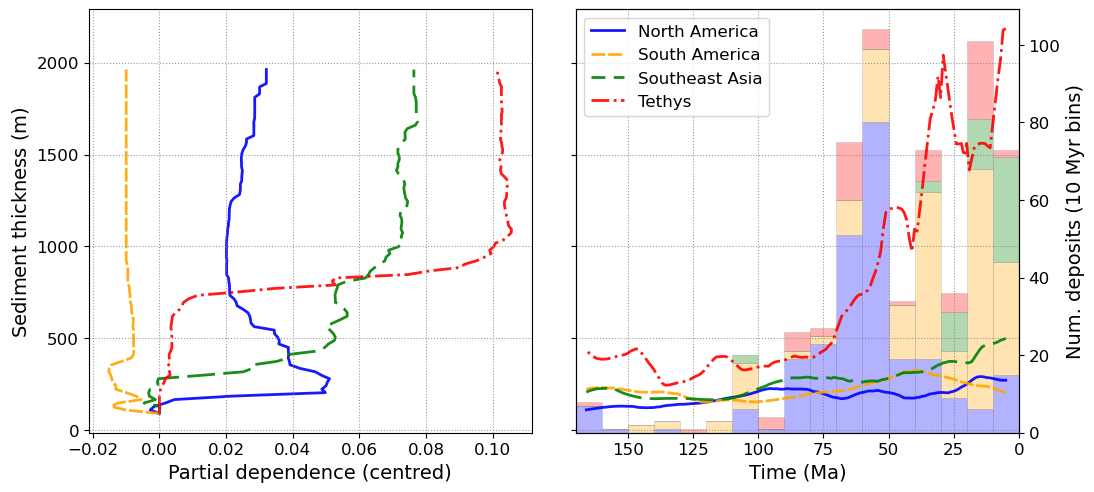

In [12]:
plot_individual = False
feature_name = "sediment_thickness (m)"
centred = True  # centre partial dependence plots
window_size = 10  # Myr window for rolling average
hist_bin_size = 10  # Myr bin size for histogram
linewidth = 2

fig, axs = plt.subplots(
    1, 2,
    figsize=(12, 5.5),
    sharey=True,
    gridspec_kw=dict(
        wspace=0.1,
    ),
)
ax1, ax2 = np.ravel(axs)
ax3 = ax2.twinx()

ymin, ymax = np.inf, -np.inf

colors = ("blue", "orange", "green", "red")
for region, linestyle, color in zip_longest(sorted(regions), linestyles, colors):
    feature_names_region = feature_names_regions[region]
    if feature_name in feature_names_region:
        idx = np.squeeze(np.where(feature_names_region == feature_name))
        pd_results_region = pd_results_regions[region]
        x = pd_results_region[idx]["grid_values"][0]
        ys = pd_results_region[idx]["individual"][0].T
        y_av = pd_results_region[idx]["average"][0]

        if feature_name == "total_carbon_density (t/m^2)":
            x_interp = np.linspace(6.0, x.max(), x.size)
            y_av = np.interp(x_interp, x, y_av)
            ys_interp = np.empty((x_interp.size, ys.shape[1]), dtype=ys.dtype)
            for i in range(ys.shape[1]):
                ys_interp[:, i] = np.interp(x_interp, x, ys[:, i])
            ys = ys_interp
            x = x_interp

        if centred:
            ys = ys - ys[0, :]
            y_av = y_av - y_av[0]
        ax1.plot(
            y_av,
            x,
            alpha=0.9,
            linewidth=linewidth,
            linestyle=linestyle,
            color=color,
            zorder=1,
            label=region,
        )
        if plot_individual:
            ax1.plot(
                ys,
                x,
                alpha=0.01,
                linewidth=linewidth * 0.2,
                linestyle=linestyle,
                color=color,
                zorder=0.5,
            )

    subset = grid_data.groupby("region").get_group(region)
    s = subset.groupby("age (Ma)")[feature_name].quantile(0.5)
    if window_size is not None:
        s = s.rolling(window_size, center=True).mean()
    l = ax2.plot(
        s.index,
        s,
        label=region,
        alpha=0.9,
        linewidth=linewidth,
        color=color,
        linestyle=linestyle,
    )
    ymin = np.min((s.min(), ymin))
    ymax = np.max((s.max(), ymax))

if centred:
    ax1.set_xlabel("Partial dependence (centred)", fontsize=14)
    ax1.set_xlim(*ax1.get_xlim())
else:
    ax1.set_xlabel("Probability", fontsize=14)
    ax1.set_xlim(0, 1)
ax1.set_ylabel(format_feature_name(feature_name), fontsize=14)

yrange = ymax - ymin
ax_ymin = ymin - yrange * 0.05
ax_ymax = ymax + yrange * 0.05
if feature_name == "distance_to_trench (km)":
    ax2.set_ylim(0, 600)
ax2.legend(loc="best", fontsize=12)
ax2.set_xlim(s.index.max(), s.index.min())
ax2.set_xlabel("Time (Ma)", fontsize=14)

bins = np.arange(
    0,
    positives_subset["age (Ma)"].max() + hist_bin_size,
    hist_bin_size,
)
(
    positives_subset
        .pivot(columns="region")
        ["age (Ma)"]
        .sort_index(axis="columns")
        .plot(
            kind="hist",
            ax=ax3,
            stacked=True,
            bins=bins,
            zorder=-1,
            legend=False,
            alpha=0.3,
            color=colors,  # ensure same colours as lines
            edgecolor="grey",
            linewidth=0.5,
        )
)
ax3.set_ylabel("Num. deposits (10 Myr bins)", fontsize=14)
ax3.set_zorder(ax2.get_zorder() - 1)
ax2.patch.set_visible(False)

for ax in (*np.ravel(axs), ax3):
    ax.tick_params(labelsize=12)
for ax in np.ravel(axs):
    ax.grid(
        color="grey",
        linestyle="dotted",
        alpha=0.8,
    )

Including boxplots:

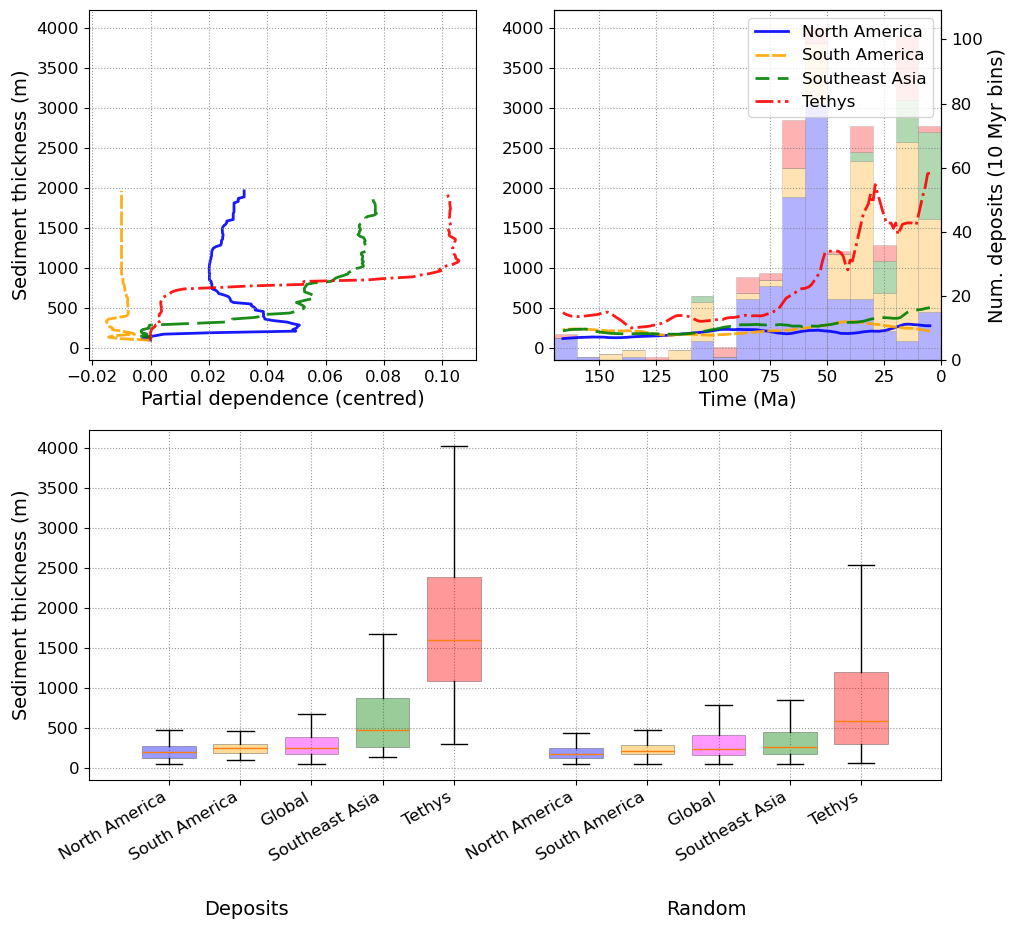

In [13]:
fig = plt.figure(figsize=(11, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = ax2.twinx()
ax4 = fig.add_subplot(gs[1, :])

axs = (ax1, ax2)

ymin, ymax = np.inf, -np.inf

colors = ("blue", "orange", "green", "red")
for region, linestyle, color in zip_longest(sorted(regions), linestyles, colors):
    feature_names_region = feature_names_regions[region]
    if feature_name in feature_names_region:
        idx = np.squeeze(np.where(feature_names_region == feature_name))
        pd_results_region = pd_results_regions[region]
        x = pd_results_region[idx]["grid_values"][0]
        ys = pd_results_region[idx]["individual"][0].T
        y_av = pd_results_region[idx]["average"][0]

        if feature_name == "total_carbon_density (t/m^2)":
            x_interp = np.linspace(6.0, x.max(), x.size)
            y_av = np.interp(x_interp, x, y_av)
            ys_interp = np.empty((x_interp.size, ys.shape[1]), dtype=ys.dtype)
            for i in range(ys.shape[1]):
                ys_interp[:, i] = np.interp(x_interp, x, ys[:, i])
            ys = ys_interp
            x = x_interp

        if centred:
            ys = ys - ys[0, :]
            y_av = y_av - y_av[0]
        ax1.plot(
            y_av,
            x,
            alpha=0.9,
            linewidth=linewidth,
            linestyle=linestyle,
            color=color,
            zorder=1,
            label=region,
        )
        if plot_individual:
            ax1.plot(
                ys,
                x,
                alpha=0.01,
                linewidth=linewidth * 0.2,
                linestyle=linestyle,
                color=color,
                zorder=0.5,
            )

    subset = grid_data.groupby("region").get_group(region)
    s = subset.groupby("age (Ma)")[feature_name].quantile(0.5)
    if window_size is not None:
        s = s.rolling(window_size, center=True).mean()
    l = ax2.plot(
        s.index,
        s,
        label=region,
        alpha=0.9,
        linewidth=linewidth,
        color=color,
        linestyle=linestyle,
    )
    ymin = np.min((s.min(), ymin))
    ymax = np.max((s.max(), ymax))

if centred:
    ax1.set_xlabel("Partial dependence (centred)", fontsize=14)
    ax1.set_xlim(*ax1.get_xlim())
else:
    ax1.set_xlabel("Probability", fontsize=14)
    ax1.set_xlim(0, 1)
ax1.set_ylabel(format_feature_name(feature_name), fontsize=14)

yrange = ymax - ymin
ax_ymin = ymin - yrange * 0.05
ax_ymax = ymax + yrange * 0.05
if feature_name == "distance_to_trench (km)":
    ax2.set_ylim(0, 600)
ax2.legend(loc="best", fontsize=12)
ax2.set_xlim(s.index.max(), s.index.min())
ax2.set_xlabel("Time (Ma)", fontsize=14)

bins = np.arange(
    0,
    positives_subset["age (Ma)"].max() + hist_bin_size,
    hist_bin_size,
)
(
    positives_subset
        .pivot(columns="region")
        ["age (Ma)"]
        .sort_index(axis="columns")
        .plot(
            kind="hist",
            ax=ax3,
            stacked=True,
            bins=bins,
            zorder=-1,
            legend=False,
            alpha=0.3,
            color=colors,  # ensure same colours as lines
            edgecolor="grey",
            linewidth=0.5,
        )
)
ax3.set_ylabel("Num. deposits (10 Myr bins)", fontsize=14)
ax3.set_zorder(ax2.get_zorder() - 1)
ax2.patch.set_visible(False)

# Boxplots
x_pos = []
x_rand = []
offsets = np.linspace(-0.35, 0.35, len(regions_boxplots))
widths = 0.75 * (offsets[1] - offsets[0])
for region, color, offset in zip(regions_boxplots, colors_boxplots, offsets):
    if region == "Global":
        positives_region = positives
        random_region = random
    else:
        positives_region = gb_positives.get_group(region)
        random_region = gb_random.get_group(region)
    x = [
        positives_region[feature_name].dropna(),
        random_region[feature_name].dropna(),
    ]
    ax4.boxplot(
        x,
        positions=[offset, (offset + 1)],
        vert=True,
        widths=widths,
        labels=[region, region],
        showfliers=False,
        patch_artist=True,
        boxprops=dict(
            facecolor=color,
            edgecolor="black",
            linewidth=0.5,
            linestyle="dashed",
            alpha=0.4,
        ),
    )
ax4.set_ylabel(format_feature_name(feature_name), fontsize=14)
ax4.set_xlim(
    offsets.min() - widths * 1.5,
    (1 + offsets.max()) + widths * 1.5
)
ax4.set_xticks(
    ax4.get_xticks(),
    ax4.get_xticklabels(),
    rotation=30,
    ha="right",
)
ax4.text(
    0.23, -0.025,
    "Deposits",
    fontsize=14,
    transform=fig.transFigure,
)
ax4.text(
    0.65, -0.025,
    "Random",
    fontsize=14,
    transform=fig.transFigure,
)

for ax in (ax1, ax2, ax3, ax4):
    ax.tick_params(labelsize=12)
for ax in (ax1, ax2, ax4):
    ax.grid(
        color="grey",
        linestyle="dotted",
        alpha=0.8,
    )

ymin, ymax = np.inf, -np.inf
for ax in (ax1, ax2, ax4):
    ymin = min(ymin, ax.get_ylim()[0])
    ymax = max(ymax, ax.get_ylim()[1])
for ax in (ax1, ax2, ax4):
    ax.set_ylim(ymin, ymax)

#### Create all plots

In [14]:
centred = True
plot_individual = False

all_feature_names = set()
for feature_names_region in feature_names_regions.values():
    all_feature_names = all_feature_names.union(feature_names_region)

figures_dir_regions = os.path.join(pd_dir, "figures_regions")
os.makedirs(figures_dir_regions, exist_ok=True)

for feature_name in all_feature_names:
    output_filename = os.path.join(
        figures_dir_regions,
        f"{feature_name.split()[0]}",
    )

    fig, axs = plt.subplots(
        1, 2,
        figsize=(12, 5.5),
        sharey=True,
        gridspec_kw=dict(
            wspace=0.1,
        ),
    )
    ax1, ax2 = np.ravel(axs)
    ax3 = ax2.twinx()

    ymin, ymax = np.inf, -np.inf

    for region, linestyle, color in zip_longest(sorted(regions), linestyles, colors):
        feature_names_region = feature_names_regions[region]
        if feature_name in feature_names_region:
            idx = np.squeeze(np.where(feature_names_region == feature_name))
            pd_results_region = pd_results_regions[region]
            x = pd_results_region[idx]["grid_values"][0]
            ys = pd_results_region[idx]["individual"][0].T
            y_av = pd_results_region[idx]["average"][0]

            if feature_name == "total_carbon_density (t/m^2)":
                x_interp = np.linspace(6.0, x.max(), x.size)
                y_av = np.interp(x_interp, x, y_av)
                ys_interp = np.empty((x_interp.size, ys.shape[1]), dtype=ys.dtype)
                for i in range(ys.shape[1]):
                    ys_interp[:, i] = np.interp(x_interp, x, ys[:, i])
                ys = ys_interp
                x = x_interp

            if centred:
                ys = ys - ys[0, :]
                y_av = y_av - y_av[0]
            ax1.plot(
                y_av,
                x,
                alpha=0.9,
                linewidth=linewidth,
                linestyle=linestyle,
                color=color,
                zorder=1,
                label=region,
            )
            if plot_individual:
                ax1.plot(
                    ys,
                    x,
                    alpha=0.05,
                    linewidth=linewidth * 0.2,
                    linestyle=linestyle,
                    color=color,
                    zorder=0.5,
                )

        subset = grid_data.groupby("region").get_group(region)
        s = subset.groupby("age (Ma)")[feature_name].quantile(0.5)
        if window_size is not None:
            s = s.rolling(window_size, center=True).mean()
        l = ax2.plot(
            s.index,
            s,
            label=region,
            alpha=0.9,
            linewidth=linewidth,
            color=color,
            linestyle=linestyle,
        )
        ymin = np.min((s.min(), ymin))
        ymax = np.max((s.max(), ymax))

    if centred:
        ax1.set_xlabel("Partial dependence (centred)", fontsize=14)
        ax1.set_xlim(*ax1.get_xlim())
    else:
        ax1.set_xlabel("Probability", fontsize=14)
        ax1.set_xlim(0, 1)
    ax1.set_ylabel(format_feature_name(feature_name), fontsize=14)

    if feature_name == "distance_to_trench (km)":
        ax2.set_ylim(0, 600)
    ax2.legend(loc="best", fontsize=12)
    ax2.set_xlim(s.index.max(), s.index.min())
    ax2.set_xlabel("Time (Ma)", fontsize=14)

    bins = np.arange(
        0,
        positives_subset["age (Ma)"].max() + hist_bin_size,
        hist_bin_size,
    )
    (
        positives_subset
            .pivot(columns="region")
            ["age (Ma)"]
            .sort_index(axis="columns")
            .plot(
                kind="hist",
                ax=ax3,
                stacked=True,
                bins=bins,
                zorder=-1,
                legend=False,
                alpha=0.3,
                color=colors,  # ensure same colours as lines
                edgecolor="grey",
                linewidth=0.5,
            )
    )
    ax3.set_ylabel("Num. deposits (10 Myr bins)", fontsize=14)
    ax3.set_zorder(ax2.get_zorder() - 1)
    ax2.patch.set_visible(False)

    for ax in (*np.ravel(axs), ax3):
        ax.tick_params(labelsize=12)
    for ax in np.ravel(axs):
        ax.grid(
            color="grey",
            linestyle="dotted",
            alpha=0.8,
        )

    for ext in (".pdf", ".png"):
        fig.savefig(output_filename + ext, dpi=350, bbox_inches="tight")
    plt.close(fig)

Include boxplots:

In [15]:
figures_dir_boxplots = os.path.join(pd_dir, "figures_regions_boxplots")
os.makedirs(figures_dir_boxplots, exist_ok=True)
for feature_name in all_feature_names:
    output_filename = os.path.join(
        figures_dir_boxplots,
        f"{feature_name.split()[0]}",
    )
    fig = plt.figure(figsize=(11, 10))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = ax2.twinx()
    ax4 = fig.add_subplot(gs[1, :])

    axs = (ax1, ax2)

    ymin, ymax = np.inf, -np.inf

    colors = ("blue", "orange", "green", "red")
    for region, linestyle, color in zip_longest(sorted(regions), linestyles, colors):
        feature_names_region = feature_names_regions[region]
        if feature_name in feature_names_region:
            idx = np.squeeze(np.where(feature_names_region == feature_name))
            pd_results_region = pd_results_regions[region]
            x = pd_results_region[idx]["grid_values"][0]
            ys = pd_results_region[idx]["individual"][0].T
            y_av = pd_results_region[idx]["average"][0]

            if feature_name == "total_carbon_density (t/m^2)":
                x_interp = np.linspace(6.0, x.max(), x.size)
                y_av = np.interp(x_interp, x, y_av)
                ys_interp = np.empty((x_interp.size, ys.shape[1]), dtype=ys.dtype)
                for i in range(ys.shape[1]):
                    ys_interp[:, i] = np.interp(x_interp, x, ys[:, i])
                ys = ys_interp
                x = x_interp

            if centred:
                ys = ys - ys[0, :]
                y_av = y_av - y_av[0]
            ax1.plot(
                y_av,
                x,
                alpha=0.9,
                linewidth=linewidth,
                linestyle=linestyle,
                color=color,
                zorder=1,
                label=region,
            )
            if plot_individual:
                ax1.plot(
                    ys,
                    x,
                    alpha=0.01,
                    linewidth=linewidth * 0.2,
                    linestyle=linestyle,
                    color=color,
                    zorder=0.5,
                )

        subset = grid_data.groupby("region").get_group(region)
        s = subset.groupby("age (Ma)")[feature_name].quantile(0.5)
        if window_size is not None:
            s = s.rolling(window_size, center=True).mean()
        l = ax2.plot(
            s.index,
            s,
            label=region,
            alpha=0.9,
            linewidth=linewidth,
            color=color,
            linestyle=linestyle,
        )
        ymin = np.min((s.min(), ymin))
        ymax = np.max((s.max(), ymax))

    if centred:
        ax1.set_xlabel("Partial dependence (centred)", fontsize=14)
        ax1.set_xlim(*ax1.get_xlim())
    else:
        ax1.set_xlabel("Probability", fontsize=14)
        ax1.set_xlim(0, 1)
    ax1.set_ylabel(format_feature_name(feature_name), fontsize=14)

    yrange = ymax - ymin
    ax_ymin = ymin - yrange * 0.05
    ax_ymax = ymax + yrange * 0.05
    if feature_name == "distance_to_trench (km)":
        ax2.set_ylim(0, 600)
    ax2.legend(loc="best", fontsize=12)
    ax2.set_xlim(s.index.max(), s.index.min())
    ax2.set_xlabel("Time (Ma)", fontsize=14)

    bins = np.arange(
        0,
        positives_subset["age (Ma)"].max() + hist_bin_size,
        hist_bin_size,
    )
    (
        positives_subset
            .pivot(columns="region")
            ["age (Ma)"]
            .sort_index(axis="columns")
            .plot(
                kind="hist",
                ax=ax3,
                stacked=True,
                bins=bins,
                zorder=-1,
                legend=False,
                alpha=0.3,
                color=colors,  # ensure same colours as lines
                edgecolor="grey",
                linewidth=0.5,
            )
    )
    ax3.set_ylabel("Num. deposits (10 Myr bins)", fontsize=14)
    ax3.set_zorder(ax2.get_zorder() - 1)
    ax2.patch.set_visible(False)

    # Boxplots
    x_pos = []
    x_rand = []
    offsets = np.linspace(-0.35, 0.35, len(regions_boxplots))
    widths = 0.75 * (offsets[1] - offsets[0])
    for region, color, offset in zip(regions_boxplots, colors_boxplots, offsets):
        if region == "Global":
            positives_region = positives
            random_region = random
        else:
            positives_region = gb_positives.get_group(region)
            random_region = gb_random.get_group(region)
        x = [
            positives_region[feature_name].dropna(),
            random_region[feature_name].dropna(),
        ]
        ax4.boxplot(
            x,
            positions=[offset, (offset + 1)],
            vert=True,
            widths=widths,
            labels=[region, region],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(
                facecolor=color,
                edgecolor="black",
                linewidth=0.5,
                linestyle="dashed",
                alpha=0.4,
            ),
        )
    ax4.set_ylabel(format_feature_name(feature_name), fontsize=14)
    ax4.set_xlim(
        offsets.min() - widths * 1.5,
        (1 + offsets.max()) + widths * 1.5
    )
    ax4.set_xticks(
        ax4.get_xticks(),
        ax4.get_xticklabels(),
        rotation=30,
        ha="right",
    )
    ax4.text(
        0.23, -0.025,
        "Deposits",
        fontsize=14,
        transform=fig.transFigure,
    )
    ax4.text(
        0.65, -0.025,
        "Random",
        fontsize=14,
        transform=fig.transFigure,
    )

    for ax in (ax1, ax2, ax3, ax4):
        ax.tick_params(labelsize=12)
    for ax in (ax1, ax2, ax4):
        ax.grid(
            color="grey",
            linestyle="dotted",
            alpha=0.8,
        )

    ymin, ymax = np.inf, -np.inf
    for ax in (ax1, ax2, ax4):
        ymin = min(ymin, ax.get_ylim()[0])
        ymax = max(ymax, ax.get_ylim()[1])
    for ax in (ax1, ax2, ax4):
        ax.set_ylim(ymin, ymax)

    for ext in (".pdf", ".png"):
        fig.savefig(output_filename + ext, dpi=350, bbox_inches="tight")
    plt.close(fig)